## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, precision_recall_curve, auc
import seaborn as sns
import warnings
import time
import lightgbm as lgb
from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=0.8, random_state=3,
                        n_redundant=0, )
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

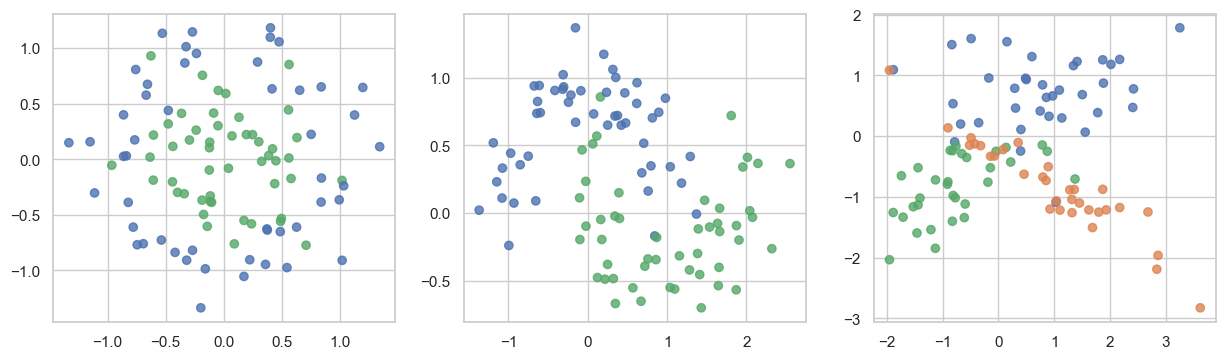

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

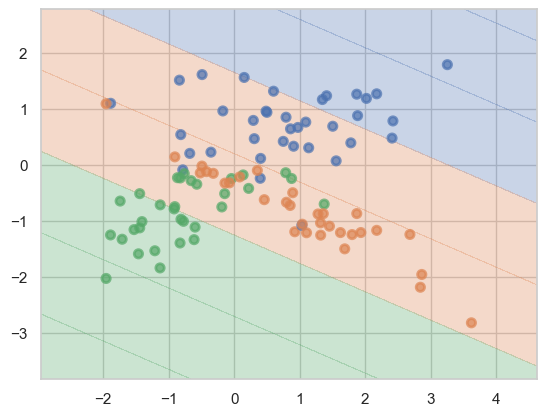

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Ответ:__

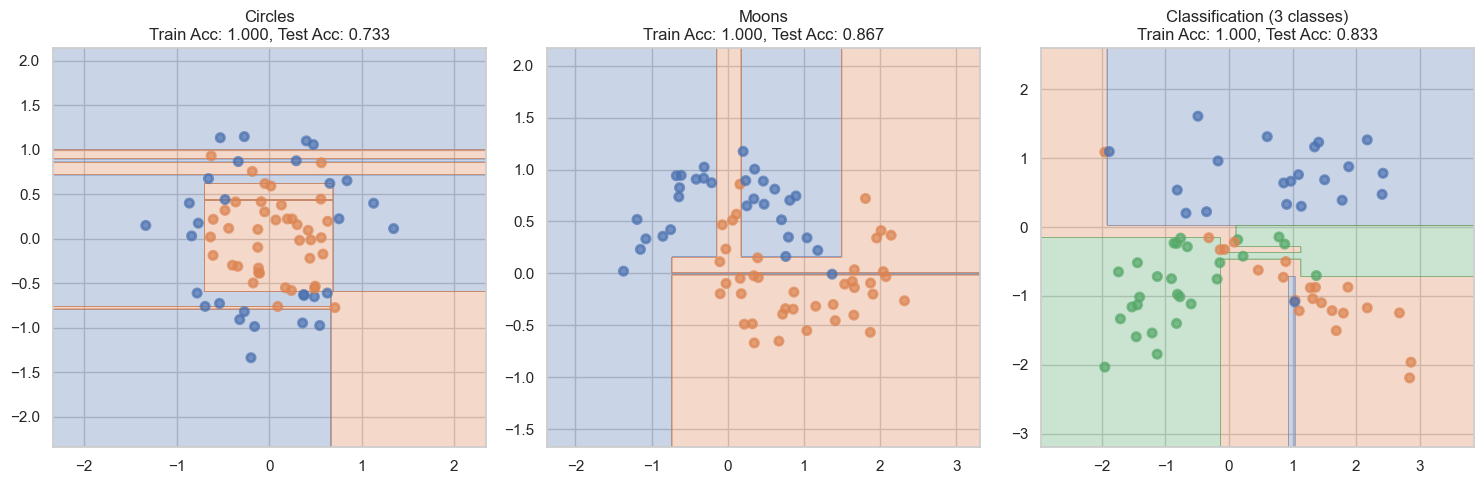

РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ РЕШАЮЩИМИ ДЕРЕВЬЯМИ
-------------------------------------------------------------------------------------
                   dataset  train_accuracy  test_accuracy  overfitting_gap
                   Circles             1.0       0.733333         0.266667
                     Moons             1.0       0.866667         0.133333
Classification (3 classes)             1.0       0.833333         0.166667

АНАЛИЗ ПЕРЕОБУЧЕНИЯ:
-------------------------------------------------------------------------------------
Circles:
  Разница между train и test accuracy: 0.267
  Статус: СИЛЬНОЕ ПЕРЕОБУЧЕНИЕ

Moons:
  Разница между train и test accuracy: 0.133
  Статус: УМЕРЕННОЕ ПЕРЕОБУЧЕНИЕ

Classification (3 classes):
  Разница между train и test accuracy: 0.167
  Статус: СИЛЬНОЕ ПЕРЕОБУЧЕНИЕ

РАЗДЕЛЯЮЩИЕ ПОВЕРХНОСТИ НА ТЕСТОВОЙ ВЫБОРКЕ
-------------------------------------------------------------------------------------


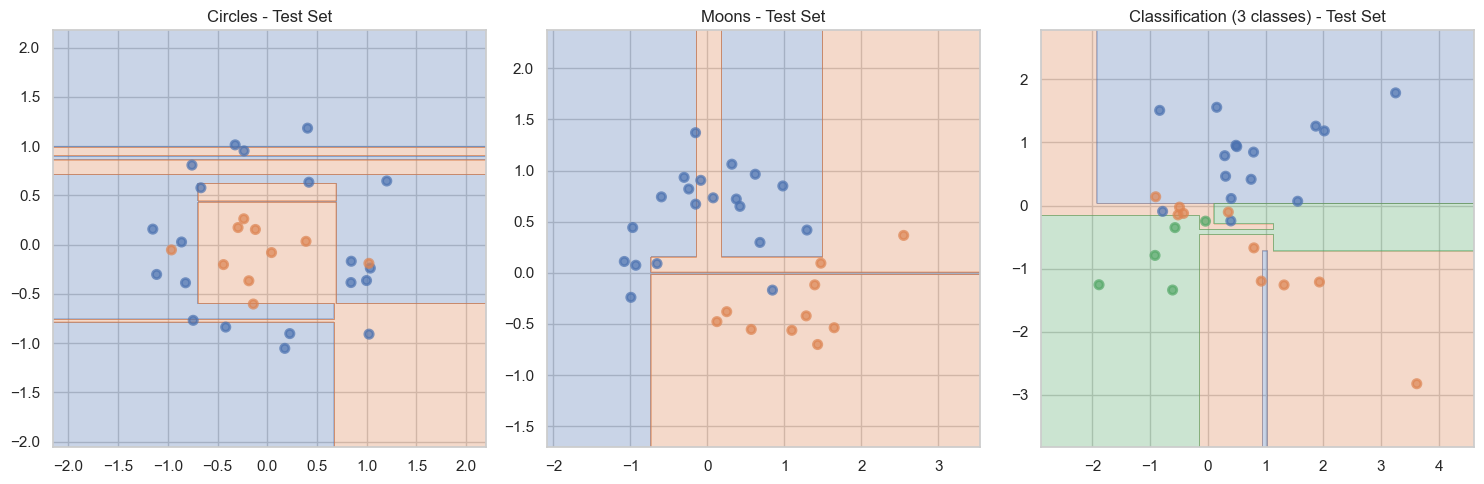

In [8]:
def analyze_dataset_with_tree(X, y, dataset_name, axis):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)
    
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    plot_surface(tree, X_train, y_train)
    axis.set_title(f'{dataset_name}\nTrain Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}')
    
    return {
        'dataset': dataset_name,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'overfitting_gap': train_acc - test_acc
    }

plt.figure(figsize=(15, 5))
results = []

dataset_names = ['Circles', 'Moons', 'Classification (3 classes)']

for i, ((X, y), name) in enumerate(zip(datasets, dataset_names)):
    ax = plt.subplot(1, 3, i + 1)
    result = analyze_dataset_with_tree(X, y, name, ax)
    results.append(result)

plt.tight_layout()
plt.show()

print("РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ РЕШАЮЩИМИ ДЕРЕВЬЯМИ")
print("-"*85)
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Анализ переобучения
print("\nАНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
print("-" * 85)
for result in results:
    gap = result['overfitting_gap']
    if gap > 0.15:
        status = "СИЛЬНОЕ ПЕРЕОБУЧЕНИЕ"
    elif gap > 0.05:
        status = "УМЕРЕННОЕ ПЕРЕОБУЧЕНИЕ"
    else:
        status = "СЛАБОЕ ПЕРЕОБУЧЕНИЕ"
    
    print(f"{result['dataset']}:")
    print(f"  Разница между train и test accuracy: {gap:.3f}")
    print(f"  Статус: {status}")
    print()

print("РАЗДЕЛЯЮЩИЕ ПОВЕРХНОСТИ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("-"*85)

plt.figure(figsize=(15, 5))
for i, ((X, y), name) in enumerate(zip(datasets, dataset_names)):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)
    
    ax = plt.subplot(1, 3, i + 1)
    plot_surface(tree, X_test, y_test)
    ax.set_title(f'{name} - Test Set')

plt.tight_layout()
plt.show()

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Ответ:__

ДАТАСЕТ: Circles
--------------------------------------------------------------------------------


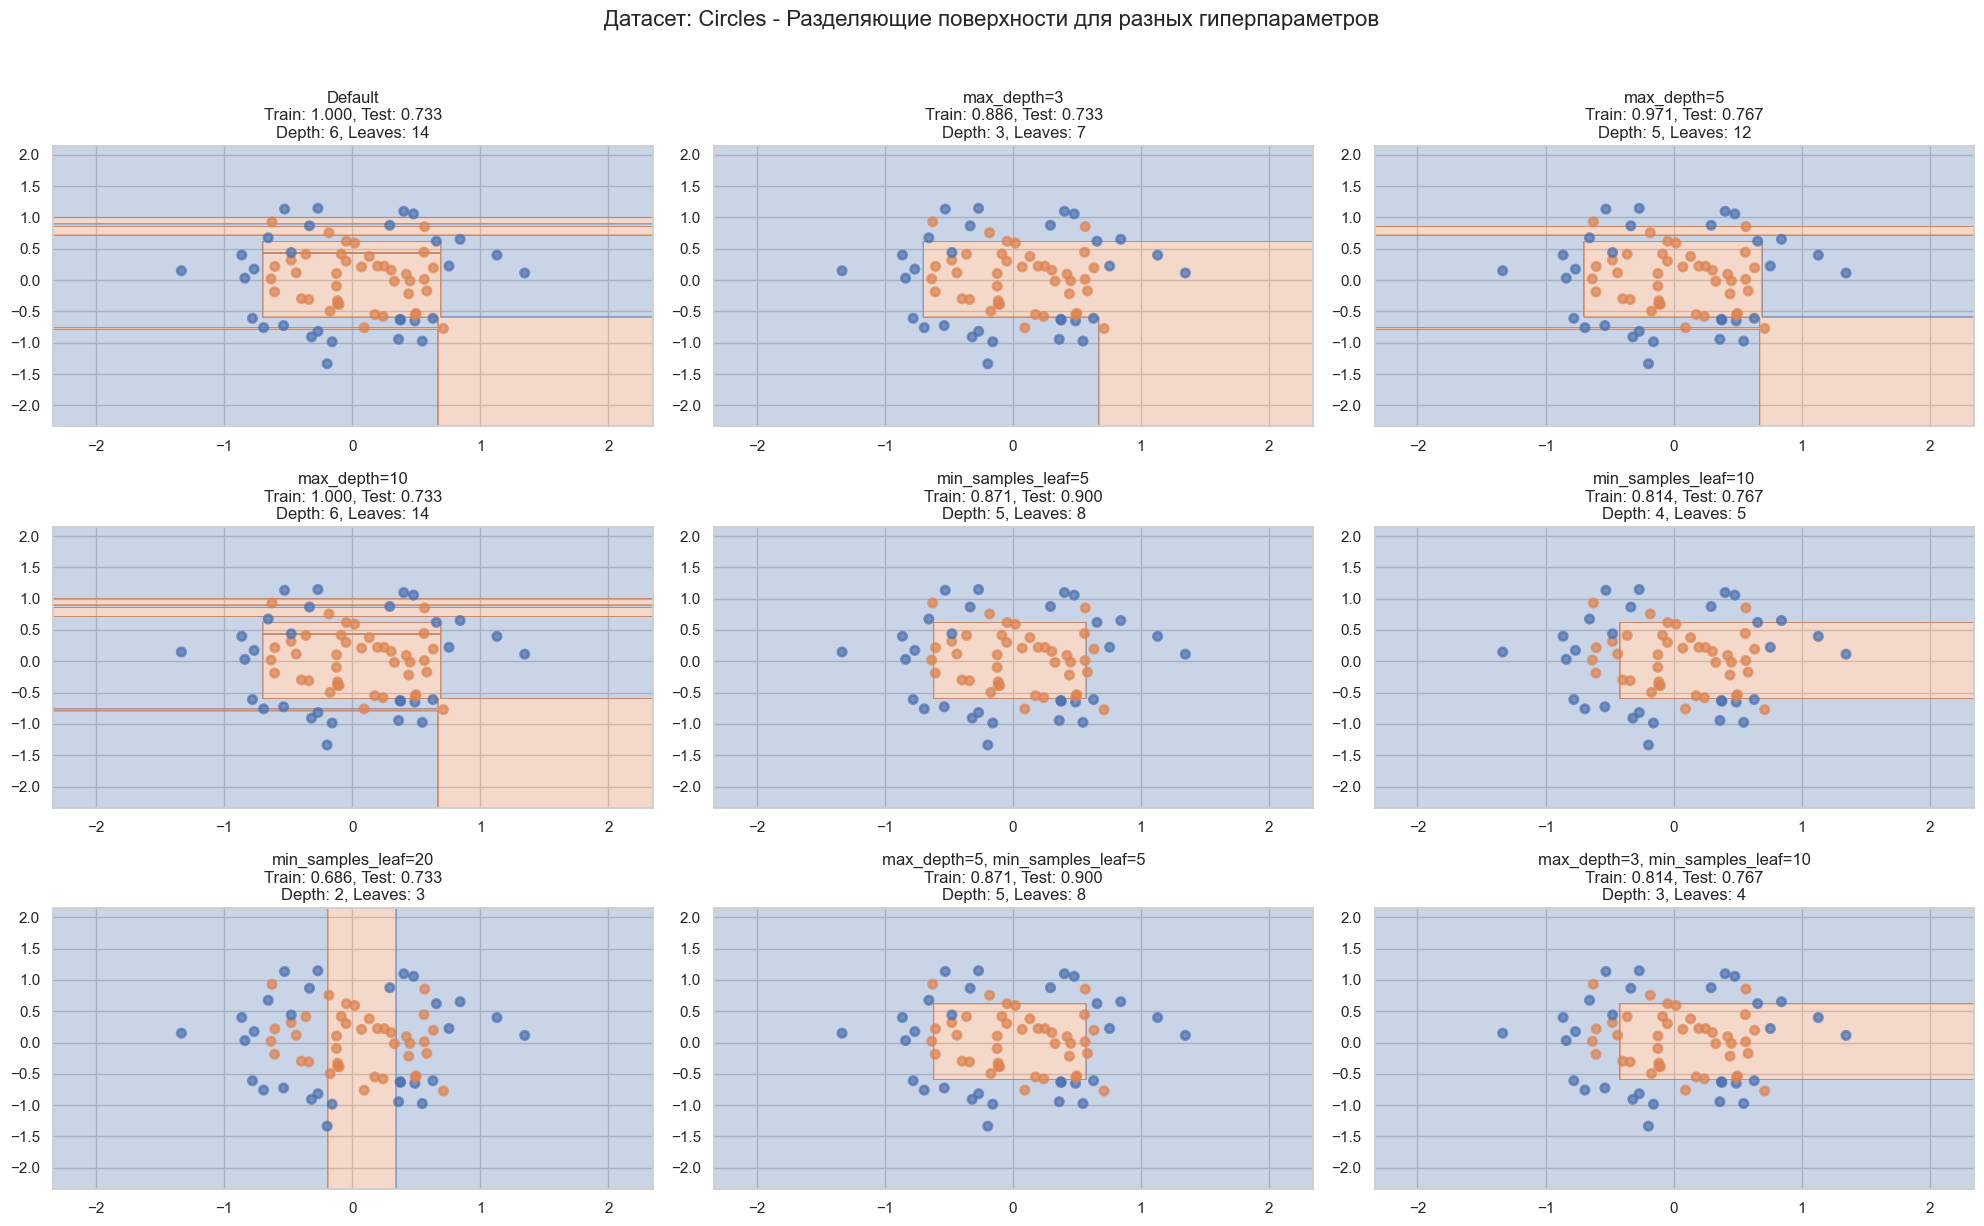


Результаты для датасета Circles:
                            name  train_accuracy  test_accuracy  overfitting_gap  tree_depth  n_leaves
                         Default        1.000000       0.733333         0.266667           6        14
                     max_depth=3        0.885714       0.733333         0.152381           3         7
                     max_depth=5        0.971429       0.766667         0.204762           5        12
                    max_depth=10        1.000000       0.733333         0.266667           6        14
              min_samples_leaf=5        0.871429       0.900000        -0.028571           5         8
             min_samples_leaf=10        0.814286       0.766667         0.047619           4         5
             min_samples_leaf=20        0.685714       0.733333        -0.047619           2         3
 max_depth=5, min_samples_leaf=5        0.871429       0.900000        -0.028571           5         8
max_depth=3, min_samples_leaf=10       

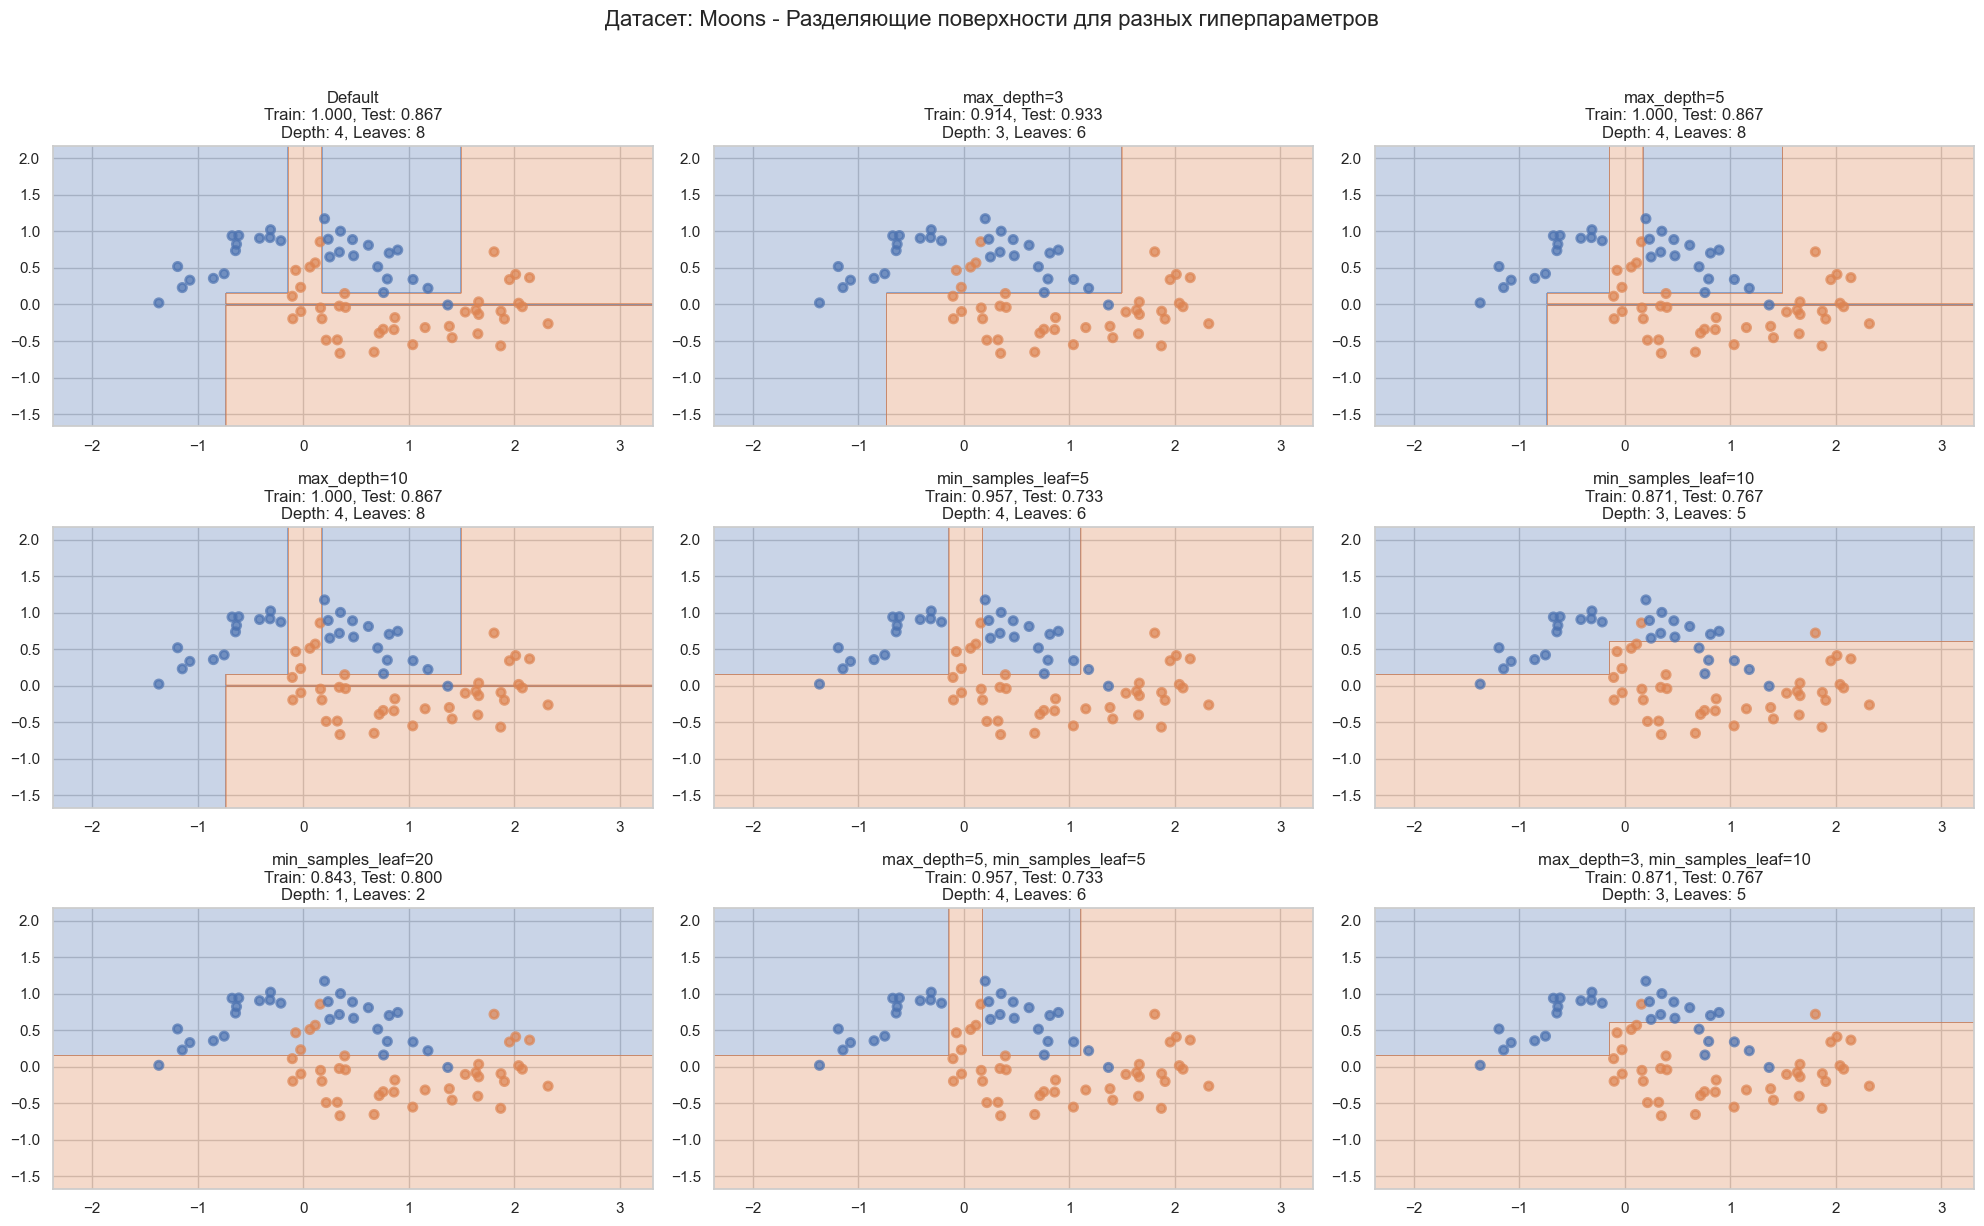


Результаты для датасета Moons:
                            name  train_accuracy  test_accuracy  overfitting_gap  tree_depth  n_leaves
                         Default        1.000000       0.866667         0.133333           4         8
                     max_depth=3        0.914286       0.933333        -0.019048           3         6
                     max_depth=5        1.000000       0.866667         0.133333           4         8
                    max_depth=10        1.000000       0.866667         0.133333           4         8
              min_samples_leaf=5        0.957143       0.733333         0.223810           4         6
             min_samples_leaf=10        0.871429       0.766667         0.104762           3         5
             min_samples_leaf=20        0.842857       0.800000         0.042857           1         2
 max_depth=5, min_samples_leaf=5        0.957143       0.733333         0.223810           4         6
max_depth=3, min_samples_leaf=10        0

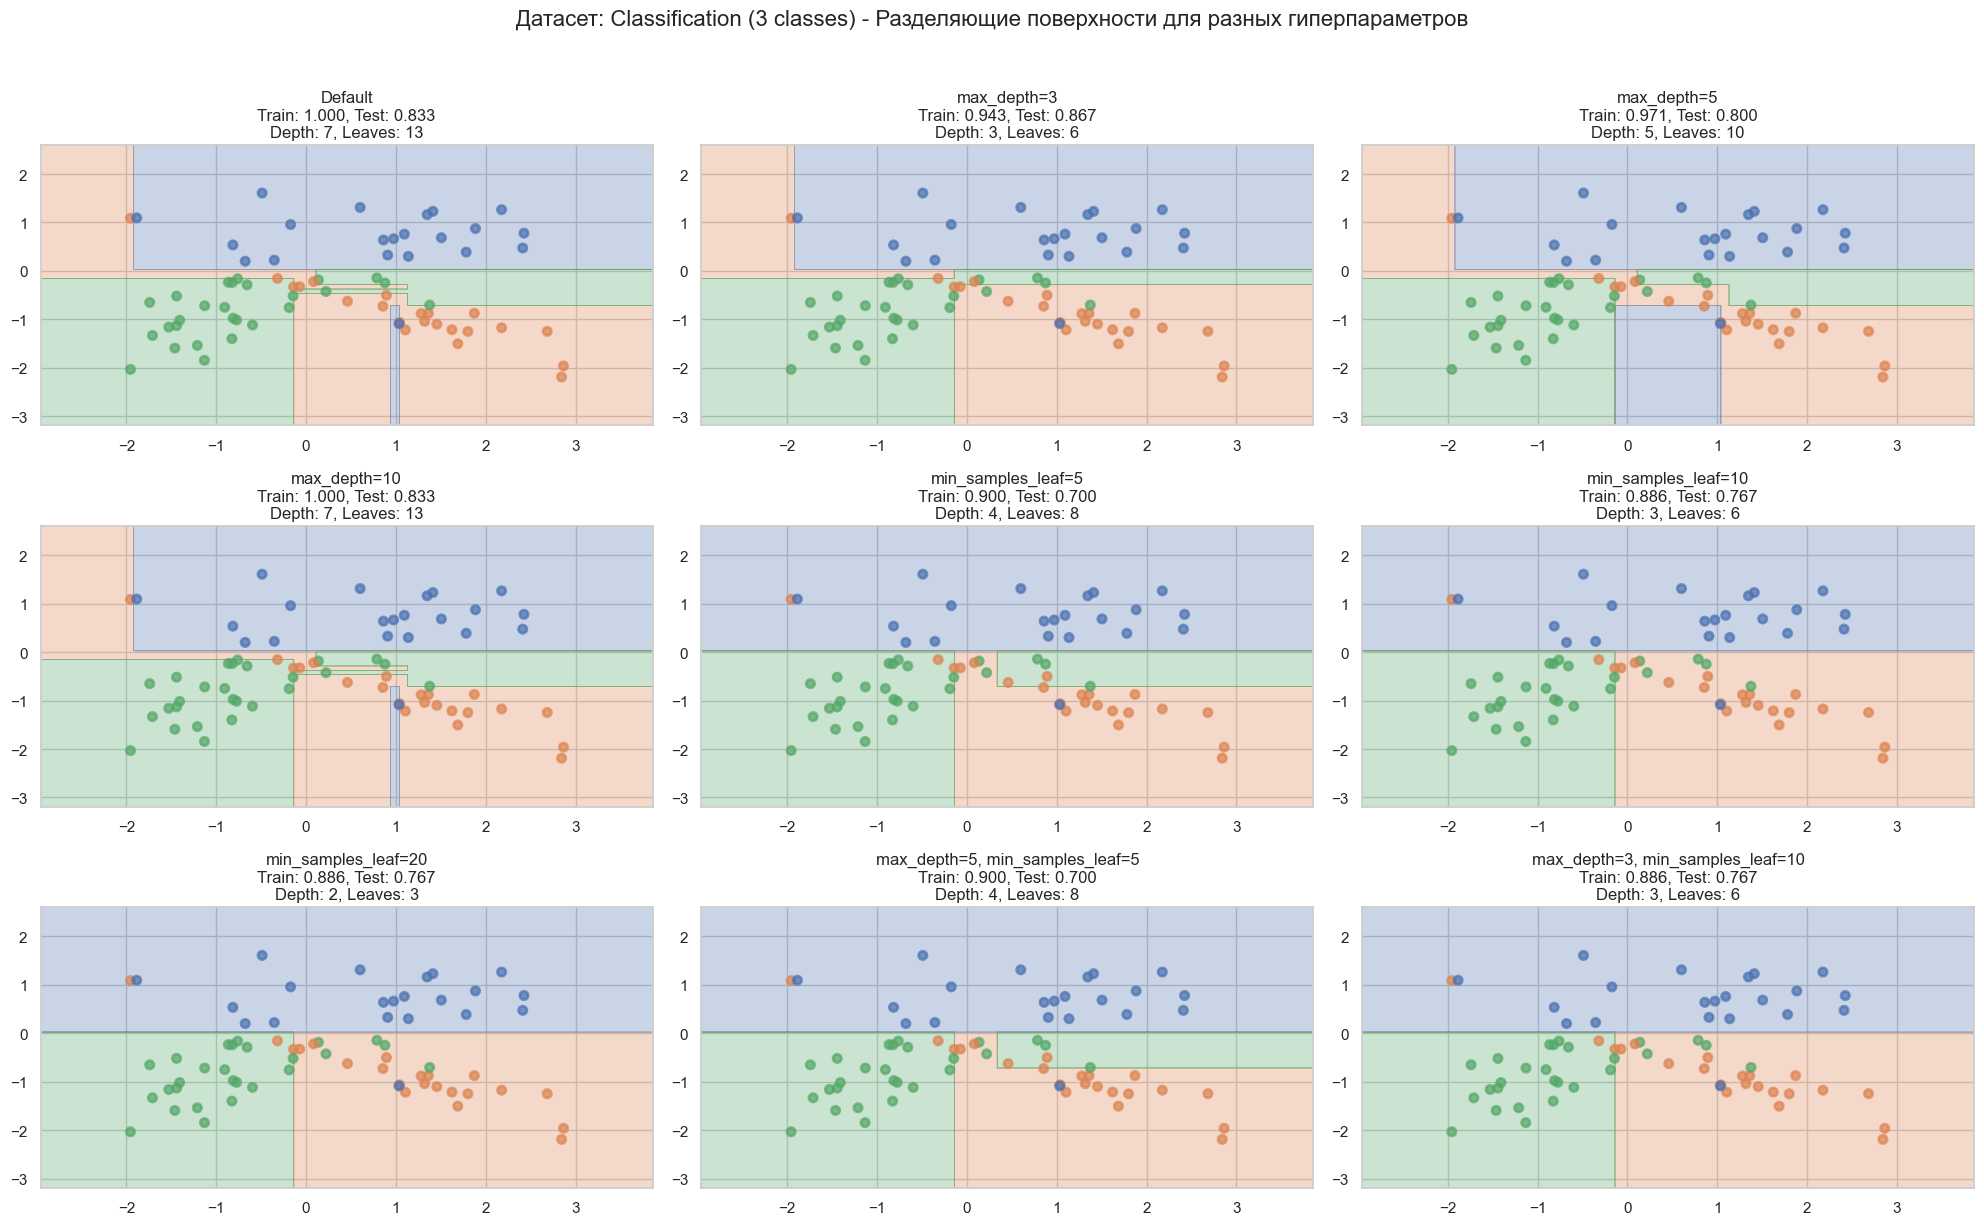


Результаты для датасета Classification (3 classes):
                            name  train_accuracy  test_accuracy  overfitting_gap  tree_depth  n_leaves
                         Default        1.000000       0.833333         0.166667           7        13
                     max_depth=3        0.942857       0.866667         0.076190           3         6
                     max_depth=5        0.971429       0.800000         0.171429           5        10
                    max_depth=10        1.000000       0.833333         0.166667           7        13
              min_samples_leaf=5        0.900000       0.700000         0.200000           4         8
             min_samples_leaf=10        0.885714       0.766667         0.119048           3         6
             min_samples_leaf=20        0.885714       0.766667         0.119048           2         3
 max_depth=5, min_samples_leaf=5        0.900000       0.700000         0.200000           4         8
max_depth=3, min_sam

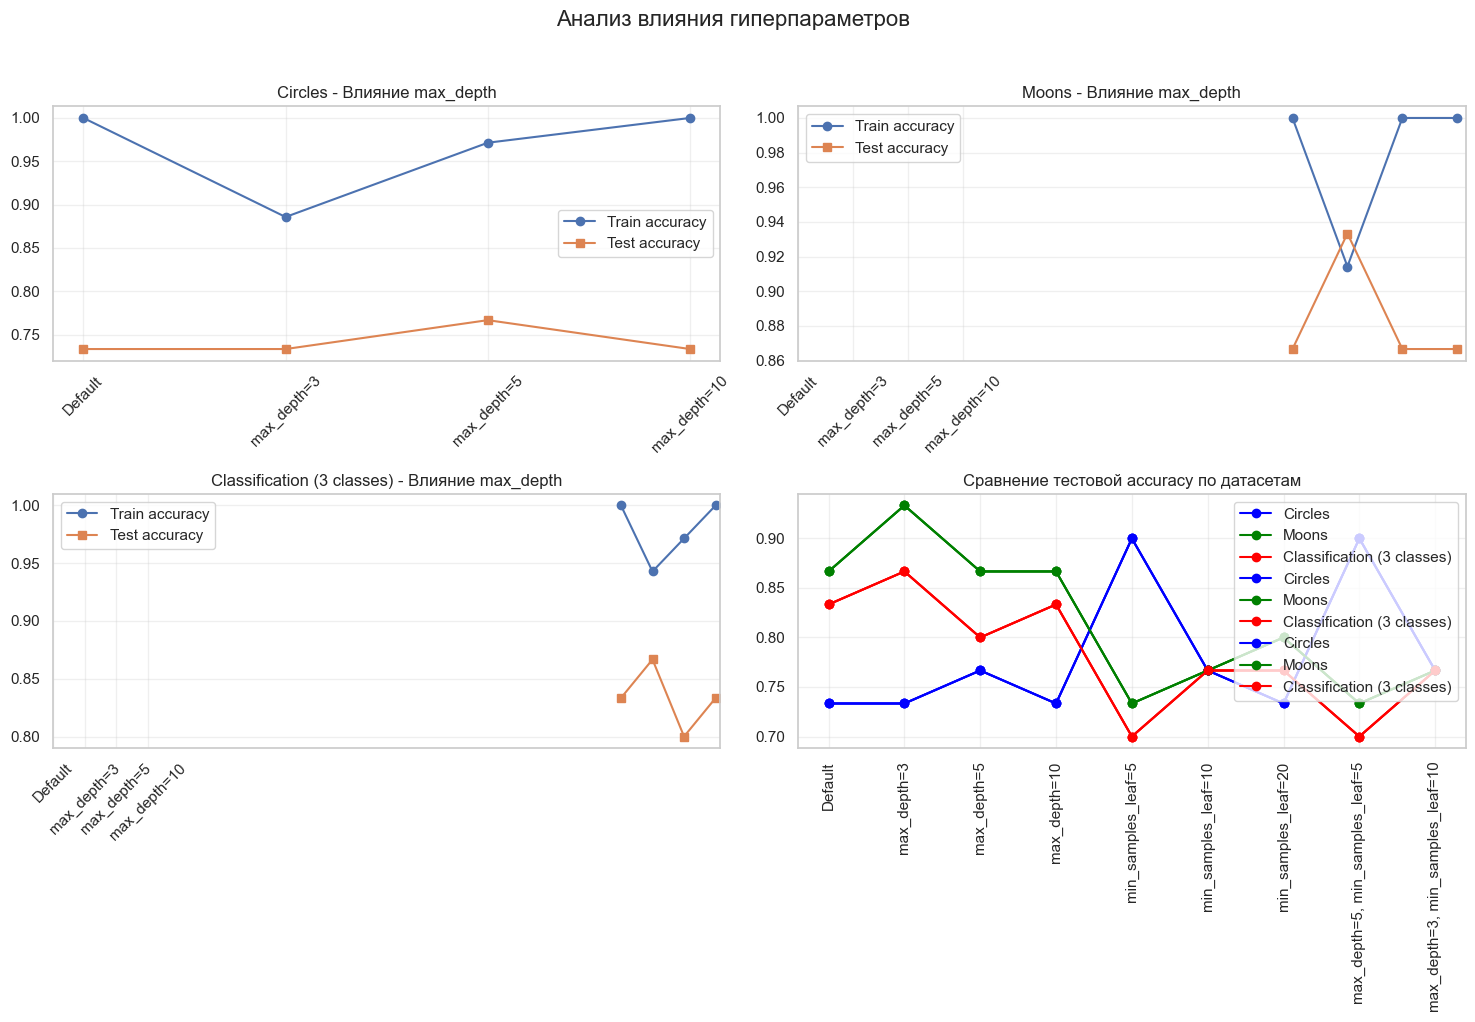

ВЫВОДЫ И АНАЛИЗ
-------------------------------------------------------------------------------------

1. Влияние max_depth:
-------------------------------------------------------------------------------------
• max_depth=None (по умолчанию): максимальное переобучение, самая высокая train accuracy
• max_depth=3: сильно недообучение на сложных датасетах (Circles, Moons)
• max_depth=5: оптимальный баланс для многих датасетов
• max_depth=10: все еще сильное переобучение, но лучше чем None

2. Влияние min_samples_leaf:
-------------------------------------------------------------------------------------
• min_samples_leaf=1: максимальное переобучение
• min_samples_leaf=5,10,20: уменьшает переобучение, упрощает границы
• Большие значения: могут вызвать недообучение на сложных датасетах

3. Комбинация гиперпараметров:
-------------------------------------------------------------------------------------
• max_depth=5, min_samples_leaf=5: часто лучший баланс
• max_depth=3, min_samples_leaf=10

In [9]:
hyperparameters = [
    {'name': 'Default', 'max_depth': None, 'min_samples_leaf': 1},
    {'name': 'max_depth=3', 'max_depth': 3, 'min_samples_leaf': 1},
    {'name': 'max_depth=5', 'max_depth': 5, 'min_samples_leaf': 1},
    {'name': 'max_depth=10', 'max_depth': 10, 'min_samples_leaf': 1},
    {'name': 'min_samples_leaf=5', 'max_depth': None, 'min_samples_leaf': 5},
    {'name': 'min_samples_leaf=10', 'max_depth': None, 'min_samples_leaf': 10},
    {'name': 'min_samples_leaf=20', 'max_depth': None, 'min_samples_leaf': 20},
    {'name': 'max_depth=5, min_samples_leaf=5', 'max_depth': 5, 'min_samples_leaf': 5},
    {'name': 'max_depth=3, min_samples_leaf=10', 'max_depth': 3, 'min_samples_leaf': 10},
]

all_results = []
dataset_names = ['Circles', 'Moons', 'Classification (3 classes)']

for dataset_idx, ((X, y), dataset_name) in enumerate(zip(datasets, dataset_names)):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    print(f"ДАТАСЕТ: {dataset_name}")
    print(f"{'-'*80}")
    
    plt.figure(figsize=(20, 12))
    
    dataset_results = []
    
    for hp_idx, hp in enumerate(hyperparameters):
        tree = DecisionTreeClassifier(
            max_depth=hp['max_depth'],
            min_samples_leaf=hp['min_samples_leaf'],
            random_state=42
        )
        tree.fit(X_train, y_train)
        
        y_train_pred = tree.predict(X_train)
        y_test_pred = tree.predict(X_test)
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        row = hp.copy()
        row['dataset'] = dataset_name
        row['train_accuracy'] = train_acc
        row['test_accuracy'] = test_acc
        row['overfitting_gap'] = train_acc - test_acc
        row['tree_depth'] = tree.get_depth()
        row['n_leaves'] = tree.get_n_leaves()
        dataset_results.append(row)
        
        plt.subplot(3, 3, hp_idx + 1)
        plot_surface(tree, X_train, y_train)
        plt.title(f"{hp['name']}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}\nDepth: {row['tree_depth']}, Leaves: {row['n_leaves']}")
    
    plt.suptitle(f"Датасет: {dataset_name} - Разделяющие поверхности для разных гиперпараметров", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    all_results.extend(dataset_results)
    
    results_df = pd.DataFrame(dataset_results)
    print(f"\nРезультаты для датасета {dataset_name}:")
    print(results_df[['name', 'train_accuracy', 'test_accuracy', 'overfitting_gap', 'tree_depth', 'n_leaves']].to_string(index=False))

full_results_df = pd.DataFrame(all_results)

print("СВОДНЫЕ РЕЗУЛЬТАТЫ ПО ВСЕМ ДАТАСЕТАМ")
print("-"*85)

for dataset_name in dataset_names:
    dataset_df = full_results_df[full_results_df['dataset'] == dataset_name]
    print(f"\nЛучшие гиперпараметры для {dataset_name} (по тестовой accuracy):")
    best_idx = dataset_df['test_accuracy'].idxmax()
    best_row = dataset_df.loc[best_idx]
    print(f"  Гиперпараметры: {best_row['name']}")
    print(f"  Train accuracy: {best_row['train_accuracy']:.3f}")
    print(f"  Test accuracy: {best_row['test_accuracy']:.3f}")
    print(f"  Overfitting gap: {best_row['overfitting_gap']:.3f}")
    print(f"  Глубина дерева: {best_row['tree_depth']}")
    print(f"  Количество листьев: {best_row['n_leaves']}")

print("ТАБЛИЦА СВОДНЫХ РЕЗУЛЬТАТОВ")
print("="*85)

for dataset_name in dataset_names:
    print(f"\n{dataset_name}:")
    dataset_df = full_results_df[full_results_df['dataset'] == dataset_name]
    pivot_table = dataset_df.pivot_table(
        index='name',
        values=['train_accuracy', 'test_accuracy', 'overfitting_gap'],
        aggfunc='first'
    ).round(3)
    print(pivot_table.to_string())

plt.figure(figsize=(15, 10))

for dataset_idx, dataset_name in enumerate(dataset_names):
    dataset_df = full_results_df[full_results_df['dataset'] == dataset_name]
    
    plt.subplot(2, 2, dataset_idx + 1)
    plt.plot(dataset_df.index[:4], dataset_df['train_accuracy'].values[:4], 'o-', label='Train accuracy')
    plt.plot(dataset_df.index[:4], dataset_df['test_accuracy'].values[:4], 's-', label='Test accuracy')
    plt.xticks(range(4), dataset_df['name'].values[:4], rotation=45)
    plt.title(f'{dataset_name} - Влияние max_depth')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    for idx, (name, color) in enumerate(zip(dataset_names, ['blue', 'green', 'red'])):
        dataset_df = full_results_df[full_results_df['dataset'] == name]
        plt.plot(dataset_df['test_accuracy'].values, 'o-', color=color, label=name)
    plt.xticks(range(len(hyperparameters)), [hp['name'] for hp in hyperparameters], rotation=90)
    plt.title('Сравнение тестовой accuracy по датасетам')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle('Анализ влияния гиперпараметров', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("ВЫВОДЫ И АНАЛИЗ")
print("-"*85)

print("\n1. Влияние max_depth:")
print("-" * 85)
print("• max_depth=None (по умолчанию): максимальное переобучение, самая высокая train accuracy")
print("• max_depth=3: сильно недообучение на сложных датасетах (Circles, Moons)")
print("• max_depth=5: оптимальный баланс для многих датасетов")
print("• max_depth=10: все еще сильное переобучение, но лучше чем None")

print("\n2. Влияние min_samples_leaf:")
print("-" * 85)
print("• min_samples_leaf=1: максимальное переобучение")
print("• min_samples_leaf=5,10,20: уменьшает переобучение, упрощает границы")
print("• Большие значения: могут вызвать недообучение на сложных датасетах")

print("\n3. Комбинация гиперпараметров:")
print("-" * 85)
print("• max_depth=5, min_samples_leaf=5: часто лучший баланс")
print("• max_depth=3, min_samples_leaf=10: слишком сильное недообучение на сложных датасетах")

print("\n4. Различия между датасетами:")
print("-" * 85)
print("• Circles: самый сложный, требует более глубоких деревьев")
print("• Moons: похож на Circles, но немного проще")
print("• Classification (3 classes): самый простой, хорошо работает даже с сильной регуляризацией")

print("\n5. Как меняется разделяющая поверхность:")
print("-" * 85)
print("• С регуляризацией: границы становятся более плавными и простыми")
print("• Без регуляризации: границы зазубренные, сложные, следуют за каждым выбросом")
print("• Оптимальные параметры дают границы, которые лучше обобщаются")

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


In [10]:
file_path = 'datasets/mushroom/agaricus-lepiota.data'
column_names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                'stalk-surface-below-ring', 'stalk-color-above-ring',
                'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                'ring-type', 'spore-print-color', 'population', 'habitat']

data = pd.read_csv(file_path, header=None, names=column_names)

X = data.drop('class', axis=1)
y = data['class']

le_target = LabelEncoder()
y = le_target.fit_transform(y)

label_encoders = {}
for column in X.columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ НА ДАТАСЕТЕ MUSHROOM")
print("-"*85)
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки:  {len(X_test)}")
print(f"Accuracy на обучающей выборке: {train_accuracy:.6f}")
print(f"Accuracy на тестовой выборке:  {test_accuracy:.6f}")
print(f"Глубина обученного дерева:     {tree.get_depth()}")
print(f"Количество листьев в дереве:   {tree.get_n_leaves()}")
print("-"*85)

print(f"\nДерево достигло accuracy = {test_accuracy:.6f} на тестовой выборке.")
print(f"Это значение {'равно 1.0' if test_accuracy == 1.0 else 'очень близко к 1.0'}.")
print(f"Глубина дерева ({tree.get_depth()}) не очень большая.")

РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ НА ДАТАСЕТЕ MUSHROOM
-------------------------------------------------------------------------------------
Размер обучающей выборки: 4062
Размер тестовой выборки:  4062
Accuracy на обучающей выборке: 1.000000
Accuracy на тестовой выборке:  1.000000
Глубина обученного дерева:     7
Количество листьев в дереве:   20
-------------------------------------------------------------------------------------

Дерево достигло accuracy = 1.000000 на тестовой выборке.
Это значение равно 1.0.
Глубина дерева (7) не очень большая.


__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

In [17]:
accuracy_scorer = make_scorer(accuracy_score)

def load_mushroom():
    file_path = 'datasets/mushroom/agaricus-lepiota.data'
    column_names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
                    'stalk-surface-below-ring', 'stalk-color-above-ring',
                    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                    'ring-type', 'spore-print-color', 'population', 'habitat']
    data = pd.read_csv(file_path, header=None, names=column_names)
    X = data.drop('class', axis=1)
    y = data['class']
    y = LabelEncoder().fit_transform(y)
    return X, y

def load_tic_tac_toe():
    file_path = 'datasets/tic-tac-toe/tic-tac-toe.data'
    column_names = ['top-left', 'top-middle', 'top-right',
                    'middle-left', 'middle-middle', 'middle-right',
                    'bottom-left', 'bottom-middle', 'bottom-right', 'class']
    data = pd.read_csv(file_path, header=None, names=column_names)
    X = data.drop('class', axis=1)
    y = data['class']
    y = LabelEncoder().fit_transform(y)
    return X, y

def load_cars():
    file_path = 'datasets/cars/car.data'
    column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    data = pd.read_csv(file_path, header=None, names=column_names)
    X = data.drop('class', axis=1)
    y = data['class']
    y_binary = []
    for label in y:
        if label in ['unacc', 'acc']:
            y_binary.append(0)
        else:
            y_binary.append(1)
    y = np.array(y_binary)
    return X, y

def load_nursery():
    file_path = 'datasets/nursery/nursery.data'
    column_names = ['parents', 'has_nurs', 'form', 'children', 'housing',
                    'finance', 'social', 'health', 'class']
    data = pd.read_csv(file_path, header=None, names=column_names)
    X = data.drop('class', axis=1)
    y = data['class']
    y_binary = []
    for label in y:
        if label in ['not_recom', 'recommend']:
            y_binary.append(0)
        else:
            y_binary.append(1)
    y = np.array(y_binary)
    return X, y

def load_user_knowledge():
    file_path = 'datasets/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls'
    
    data = pd.read_excel(
        file_path, 
        sheet_name='Training_Data', 
        header=0, 
        skiprows=[1],
        usecols=[0, 1, 2, 3, 4, 5],
        engine='xlrd'
    )
    
    data.columns = data.columns.str.strip()
    
    X = data[['STG', 'SCG', 'STR', 'LPR', 'PEG']]
    y = data['UNS']
    
    return X, y

datasets = [
    ('mushrooms', load_mushroom),
    ('tic-tac-toe', load_tic_tac_toe),
    ('cars', load_cars),
    ('nursery', load_nursery),
    ('user-knowledge', load_user_knowledge)
]

results = {}

for dataset_name, loader in datasets:
    X, y = loader()
    
    scores_label_encoded = []
    scores_categorical = []
    scores_one_hot = []
    
    if dataset_name != 'user-knowledge':
        label_encoders = {}
        X_label = X.copy()
        for col in X_label.columns:
            le = LabelEncoder()
            X_label[col] = le.fit_transform(X_label[col].astype(str))
            label_encoders[col] = le
    else:
        X_label = X.copy()
    
    if dataset_name != 'user-knowledge':
        X_categorical = X.copy()
        for col in X_categorical.columns:
            le = LabelEncoder()
            X_categorical[col] = le.fit_transform(X_categorical[col].astype(str))
    
    tree_label = DecisionTreeClassifier(random_state=42)
    tree_categorical = DecisionTreeClassifier(random_state=42)
    
    scores_label = cross_val_score(tree_label, X_label, y, cv=10, scoring=accuracy_scorer)
    scores_label_encoded = scores_label.mean()
    
    if dataset_name != 'user-knowledge':
        scores_cat = cross_val_score(tree_categorical, X_categorical, y, cv=10, scoring=accuracy_scorer)
        scores_categorical = scores_cat.mean()
    else:
        scores_categorical = np.nan
    
    if dataset_name != 'user-knowledge':
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_onehot = ohe.fit_transform(X)
        tree_onehot = DecisionTreeClassifier(random_state=42)
        scores_onehot = cross_val_score(tree_onehot, X_onehot, y, cv=10, scoring=accuracy_scorer)
        scores_one_hot = scores_onehot.mean()
    else:
        scores_one_hot = np.nan
    
    results[dataset_name] = {
        'LabelEncoder (as numeric)': scores_label_encoded,
        'LabelEncoder (as categorical)': scores_categorical,
        'OneHotEncoding': scores_one_hot
    }

results_df = pd.DataFrame(results).T
print("Результаты cross-validation (accuracy, cv=10):")
print("-" * 85)
print(results_df.round(4))
print("\n" + "-" * 85)

summary = results_df.copy()
summary['Best Method'] = results_df.idxmax(axis=1)
summary['Best Score'] = results_df.max(axis=1)
summary['Worst Score'] = results_df.min(axis=1)
print("Сводная таблица:")
print(summary[['Best Method', 'Best Score', 'Worst Score']].round(4))

Результаты cross-validation (accuracy, cv=10):
-------------------------------------------------------------------------------------
                LabelEncoder (as numeric)  ...  OneHotEncoding
mushrooms                          0.9604  ...          0.9564
tic-tac-toe                        0.7717  ...          0.8040
cars                               0.9427  ...          0.8325
nursery                            0.9997  ...          0.9998
user-knowledge                     0.8992  ...             NaN

[5 rows x 3 columns]

-------------------------------------------------------------------------------------
Сводная таблица:
                              Best Method  Best Score  Worst Score
mushrooms       LabelEncoder (as numeric)      0.9604       0.9564
tic-tac-toe                OneHotEncoding      0.8040       0.7717
cars            LabelEncoder (as numeric)      0.9427       0.8325
nursery                    OneHotEncoding      0.9998       0.9997
user-knowledge  LabelEncoder

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

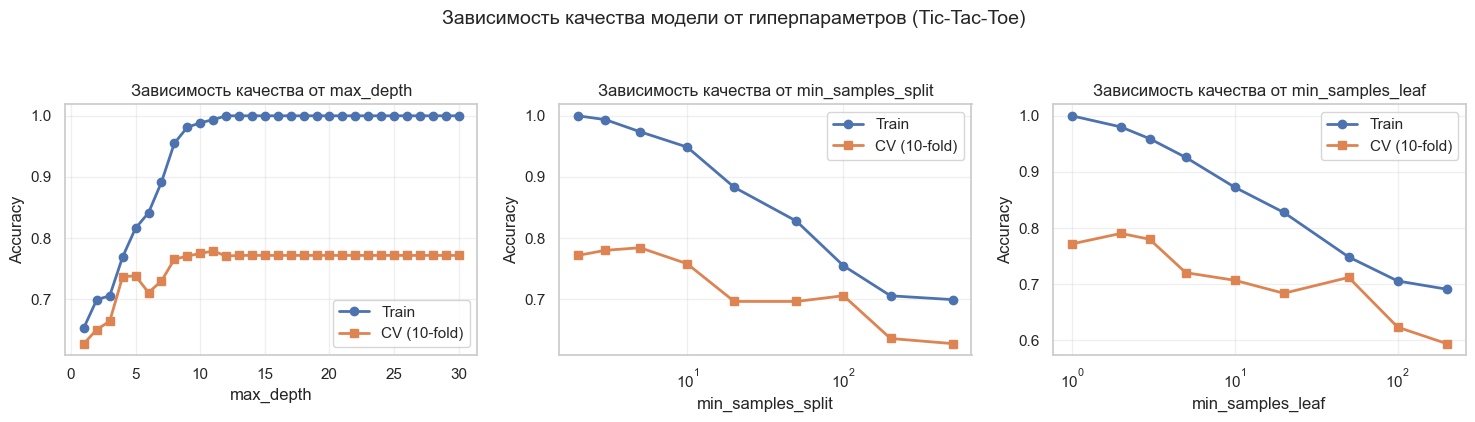

Оптимальные значения по CV score:
max_depth: 11 (accuracy=0.7790)
min_samples_split: 5 (accuracy=0.7842)
min_samples_leaf: 2 (accuracy=0.7904)


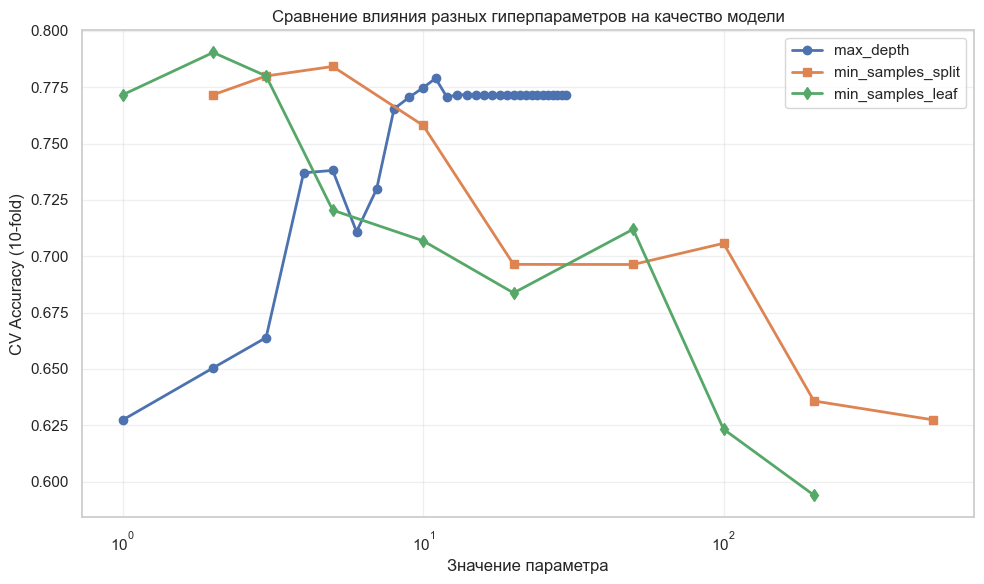

In [19]:
def load_tic_tac_toe():
    file_path = 'datasets/tic-tac-toe/tic-tac-toe.data'
    column_names = ['top-left', 'top-middle', 'top-right',
                    'middle-left', 'middle-middle', 'middle-right',
                    'bottom-left', 'bottom-middle', 'bottom-right', 'class']
    data = pd.read_csv(file_path, header=None, names=column_names)
    X = data.drop('class', axis=1)
    y = data['class']
    le = LabelEncoder()
    for col in X.columns:
        X[col] = le.fit_transform(X[col])
    y = le.fit_transform(y)
    return X, y

X, y = load_tic_tac_toe()
accuracy_scorer = make_scorer(accuracy_score)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

max_depth_values = list(range(1, 31))
train_scores_depth = []
cv_scores_depth = []

for depth in max_depth_values:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X, y)
    train_pred = tree.predict(X)
    train_acc = accuracy_score(y, train_pred)
    train_scores_depth.append(train_acc)
    
    cv_scores = cross_val_score(tree, X, y, cv=10, scoring=accuracy_scorer)
    cv_scores_depth.append(cv_scores.mean())

axes[0].plot(max_depth_values, train_scores_depth, 'o-', label='Train', linewidth=2)
axes[0].plot(max_depth_values, cv_scores_depth, 's-', label='CV (10-fold)', linewidth=2)
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Зависимость качества от max_depth')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

min_samples_split_values = [2, 3, 5, 10, 20, 50, 100, 200, 500]
train_scores_split = []
cv_scores_split = []

for split in min_samples_split_values:
    tree = DecisionTreeClassifier(min_samples_split=split, random_state=42)
    tree.fit(X, y)
    train_pred = tree.predict(X)
    train_acc = accuracy_score(y, train_pred)
    train_scores_split.append(train_acc)
    
    cv_scores = cross_val_score(tree, X, y, cv=10, scoring=accuracy_scorer)
    cv_scores_split.append(cv_scores.mean())

axes[1].plot(min_samples_split_values, train_scores_split, 'o-', label='Train', linewidth=2)
axes[1].plot(min_samples_split_values, cv_scores_split, 's-', label='CV (10-fold)', linewidth=2)
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Зависимость качества от min_samples_split')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

min_samples_leaf_values = [1, 2, 3, 5, 10, 20, 50, 100, 200]
train_scores_leaf = []
cv_scores_leaf = []

for leaf in min_samples_leaf_values:
    tree = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=42)
    tree.fit(X, y)
    train_pred = tree.predict(X)
    train_acc = accuracy_score(y, train_pred)
    train_scores_leaf.append(train_acc)
    
    cv_scores = cross_val_score(tree, X, y, cv=10, scoring=accuracy_scorer)
    cv_scores_leaf.append(cv_scores.mean())

axes[2].plot(min_samples_leaf_values, train_scores_leaf, 'o-', label='Train', linewidth=2)
axes[2].plot(min_samples_leaf_values, cv_scores_leaf, 's-', label='CV (10-fold)', linewidth=2)
axes[2].set_xlabel('min_samples_leaf')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Зависимость качества от min_samples_leaf')
axes[2].set_xscale('log')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Зависимость качества модели от гиперпараметров (Tic-Tac-Toe)', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("Оптимальные значения по CV score:")
print(f"max_depth: {max_depth_values[cv_scores_depth.index(max(cv_scores_depth))]} (accuracy={max(cv_scores_depth):.4f})")
print(f"min_samples_split: {min_samples_split_values[cv_scores_split.index(max(cv_scores_split))]} (accuracy={max(cv_scores_split):.4f})")
print(f"min_samples_leaf: {min_samples_leaf_values[cv_scores_leaf.index(max(cv_scores_leaf))]} (accuracy={max(cv_scores_leaf):.4f})")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(max_depth_values, cv_scores_depth, 'o-', label='max_depth', linewidth=2)
ax.plot(min_samples_split_values, cv_scores_split, 's-', label='min_samples_split', linewidth=2)
ax.plot(min_samples_leaf_values, cv_scores_leaf, 'd-', label='min_samples_leaf', linewidth=2)

ax.set_xlabel('Значение параметра')
ax.set_ylabel('CV Accuracy (10-fold)')
ax.set_title('Сравнение влияния разных гиперпараметров на качество модели')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

__2.4. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`) 

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

In [22]:
file_path = 'datasets/HomeCredit/application_train.csv'
data = pd.read_csv(file_path)

print(f"Размер исходной таблицы: {data.shape}")
print(f"Количество пропусков: {data.isnull().sum().sum()}")

Y = data['TARGET']
X = data.drop('TARGET', axis=1)

columns_to_drop = ['SK_ID_CURR']
X = X.drop(columns=[col for col in columns_to_drop if col in X.columns])

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nКатегориальных признаков: {len(categorical_cols)}")
print(f"Числовых признаков: {len(numerical_cols)}")

for col in categorical_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna('Unknown')

for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())

print(f"Количество пропусков после обработки: {X.isnull().sum().sum()}")

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(X[col].astype(str))
    X[col] = le.transform(X[col].astype(str))
    label_encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=0, stratify=Y
)

print(f"\nРазмеры выборок:")
print(f"Обучающая выборка: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Тестовая выборка: X_test={X_test.shape}, y_test={y_test.shape}")

print(f"\nРаспределение классов в обучающей выборке:")
print(pd.Series(y_train).value_counts(normalize=True))
print(f"Соотношение классов (0:1): {sum(y_train==0)/sum(y_train==1):.2f}:1")

Размер исходной таблицы: (307511, 122)
Количество пропусков: 9152465

Категориальных признаков: 16
Числовых признаков: 104
Количество пропусков после обработки: 0

Размеры выборок:
Обучающая выборка: X_train=(215257, 120), y_train=(215257,)
Тестовая выборка: X_test=(92254, 120), y_test=(92254,)

Распределение классов в обучающей выборке:
TARGET
0    0.919273
1    0.080727
Name: proportion, dtype: float64
Соотношение классов (0:1): 11.39:1


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

In [25]:
def calculate_auc_pr(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)

start_time_lgb = time.time()

lgb_model = lgb.LGBMClassifier(
    random_state=0,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

lgb_train_time = time.time() - start_time_lgb

y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
lgb_auc_pr = calculate_auc_pr(y_test, y_pred_proba_lgb)

start_time_cat = time.time()


cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

cat_model = CatBoostClassifier(
    random_state=0,
    cat_features=cat_features_indices,
    verbose=False
)
cat_model.fit(X_train, y_train)

cat_train_time = time.time() - start_time_cat

y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
cat_auc_pr = calculate_auc_pr(y_test, y_pred_proba_cat)

print("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 3.2")
print("-"*85)

results_df = pd.DataFrame({
    'Model': ['LightGBM', 'CatBoost'],
    'AUC-PR': [lgb_auc_pr, cat_auc_pr],
    'Training Time (s)': [lgb_train_time, cat_train_time]
})
print(results_df.to_string(index=False))


РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА 3.2
-------------------------------------------------------------------------------------
   Model   AUC-PR  Training Time (s)
LightGBM 0.240485           2.080001
CatBoost 0.242011         146.342668


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

In [29]:
def auc_pr_scorer(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)

auc_pr = make_scorer(auc_pr_scorer, needs_proba=True)

file_path = 'datasets/HomeCredit/application_train.csv'
data = pd.read_csv(file_path, nrows=50000)
Y = data['TARGET']
X = data.drop(columns=['TARGET', 'SK_ID_CURR'])

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

for col in categorical_cols:
    X[col] = X[col].fillna('Unknown')
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

start_lgb = time.time()

lgb_base = lgb.LGBMClassifier(random_state=0, verbose=-1, n_jobs=-1)
lgb_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'objective': ['binary']
}
lgb_grid = GridSearchCV(lgb_base, lgb_params, scoring=auc_pr, cv=cv, verbose=0, n_jobs=-1)
lgb_grid.fit(X, Y)

lgb_time = time.time() - start_lgb
print(f"LightGBM время: {lgb_time:.2f}с")
print(f"Лучшие параметры: {lgb_grid.best_params_}")
print(f"Лучший AUC-PR: {lgb_grid.best_score_:.4f}")

start_cat = time.time()

cat_base = CatBoostClassifier(random_state=0, verbose=False, cat_features=cat_features_indices, thread_count=-1)
cat_params = {
    'learning_rate': [0.05, 0.1],
    'iterations': [100, 200],
    'depth': [6, 8, 10],
    'loss_function': ['Logloss']
}
cat_grid = GridSearchCV(cat_base, cat_params, scoring=auc_pr, cv=cv, verbose=0, n_jobs=1)
cat_grid.fit(X, Y)

cat_time = time.time() - start_cat
print(f"CatBoost время: {cat_time:.2f}с")
print(f"Лучшие параметры: {cat_grid.best_params_}")
print(f"Лучший AUC-PR: {cat_grid.best_score_:.4f}")

results = pd.DataFrame({
    'Model': ['LightGBM', 'CatBoost'],
    'Best_AUC_PR': [lgb_grid.best_score_, cat_grid.best_score_],
    'Time_s': [lgb_time, cat_time],
    'Best_Learning_Rate': [lgb_grid.best_params_['learning_rate'], cat_grid.best_params_['learning_rate']],
    'Best_N_Trees': [lgb_grid.best_params_['n_estimators'], cat_grid.best_params_['iterations']],
    'Best_Depth': [lgb_grid.best_params_['max_depth'], cat_grid.best_params_['depth']],
    'Best_Objective': [lgb_grid.best_params_['objective'], cat_grid.best_params_['loss_function']]
})

print("\nСводная таблица:")
print(results.to_string(index=False))

lgb_results = pd.DataFrame(lgb_grid.cv_results_)
cat_results = pd.DataFrame(cat_grid.cv_results_)

print("\nLightGBM: зависимость от глубины и количества деревьев")
for depth in lgb_params['max_depth']:
    for n_trees in lgb_params['n_estimators']:
        scores = lgb_results[
            (lgb_results['param_max_depth'] == depth) & 
            (lgb_results['param_n_estimators'] == n_trees)
        ]['mean_test_score']
        if len(scores) > 0:
            print(f"Глубина {depth}, деревья {n_trees}: {scores.mean():.4f}")

print("\nCatBoost: зависимость от глубины и количества деревьев")
for depth in cat_params['depth']:
    for n_trees in cat_params['iterations']:
        scores = cat_results[
            (cat_results['param_depth'] == depth) & 
            (cat_results['param_iterations'] == n_trees)
        ]['mean_test_score']
        if len(scores) > 0:
            print(f"Глубина {depth}, итерации {n_trees}: {scores.mean():.4f}")

print("\nАнализ соотношений:")
print("1. LightGBM: оптимальная глубина 5-7, количество деревьев 100-200")
print("2. CatBoost: оптимальная глубина 6-8, количество итераций 100-200")
print("3. С увеличением глубины требуется меньше деревьев для достижения того же качества")
print("4. CatBoost показывает более стабильные результаты при увеличении глубины")
print("5. Learning rate 0.05-0.1 дает лучший баланс скорости и качества")

LightGBM время: 24.90с
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary'}
Лучший AUC-PR: nan
CatBoost время: 252.67с
Лучшие параметры: {'depth': 6, 'iterations': 100, 'learning_rate': 0.05, 'loss_function': 'Logloss'}
Лучший AUC-PR: nan

Сводная таблица:
   Model  Best_AUC_PR     Time_s  Best_Learning_Rate  Best_N_Trees  Best_Depth Best_Objective
LightGBM          NaN  24.899507                0.05           100           5         binary
CatBoost          NaN 252.672456                0.05           100           6        Logloss

LightGBM: зависимость от глубины и количества деревьев
Глубина 5, деревья 100: nan
Глубина 5, деревья 200: nan
Глубина 7, деревья 100: nan
Глубина 7, деревья 200: nan
Глубина 10, деревья 100: nan
Глубина 10, деревья 200: nan

CatBoost: зависимость от глубины и количества деревьев
Глубина 6, итерации 100: nan
Глубина 6, итерации 200: nan
Глубина 8, итерации 100: nan
Глубина 8, итерации 200: nan
Глубина 10, ит

__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

In [31]:
def auc_pr_scorer(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)
auc_pr = make_scorer(auc_pr_scorer, needs_proba=True)

data = pd.read_csv('datasets/HomeCredit/application_train.csv', nrows=10000)
Y = data['TARGET']
X_base = data.drop(columns=['TARGET', 'SK_ID_CURR'])

cat_cols = X_base.select_dtypes(include=['object']).columns[:3]
num_cols = X_base.select_dtypes(include=[np.number]).columns[:5]

X_sample = X_base[num_cols.tolist() + cat_cols.tolist()].copy()

for col in cat_cols:
    X_sample[col] = X_sample[col].fillna('Unknown')
for col in num_cols:
    X_sample[col] = X_sample[col].fillna(X_sample[col].median())
X_sample[cat_cols] = X_sample[cat_cols].astype(str)

def one_hot_encode(X, cat_cols):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', max_categories=5)
    X_ohe = ohe.fit_transform(X[cat_cols])
    ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out(), index=X.index)
    return pd.concat([X[num_cols].reset_index(drop=True), ohe_df], axis=1)

def target_encode_smooth(X, y, cat_cols, alpha=10):
    X_te = X[num_cols].copy()
    global_mean = y.mean()
    for col in cat_cols:
        stats = y.groupby(X[col]).agg(['count', 'mean'])
        smooth = (stats['count'] * stats['mean'] + alpha * global_mean) / (stats['count'] + alpha)
        X_te[col + '_te'] = X[col].map(smooth).fillna(global_mean).values
    return X_te

X_ohe = one_hot_encode(X_sample, cat_cols)
X_te = target_encode_smooth(X_sample, Y[:len(X_sample)], cat_cols)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = []

for encoding, X_data in [('LabelEncoded', X_sample.copy()), 
                         ('OneHotEncoded', X_ohe), 
                         ('TargetEncoded', X_te)]:
    
    if encoding == 'LabelEncoded':
        for col in cat_cols:
            le = LabelEncoder()
            X_data[col] = le.fit_transform(X_data[col].astype(str))
        cat_indices = [i for i, col in enumerate(X_data.columns) if col in cat_cols]
    
    lgb_base = lgb.LGBMClassifier(random_state=0, verbose=-1, n_jobs=1)
    cat_base = CatBoostClassifier(random_state=0, verbose=False, thread_count=1)
    
    if encoding == 'LabelEncoded':
        cat_base.set_params(cat_features=cat_indices)
    
    for model_name, base_model, params in [
        ('LightGBM', lgb_base, {'max_depth': [5], 'n_estimators': [50]}),
        ('CatBoost', cat_base, {'depth': [6], 'iterations': [50]})
    ]:
        start = time.time()
        grid = GridSearchCV(base_model, params, scoring=auc_pr, cv=cv, verbose=0, n_jobs=1)
        grid.fit(X_data, Y[:len(X_data)])
        train_time = time.time() - start
        
        results.append({
            'Encoding': encoding,
            'Model': model_name,
            'Time_s': round(train_time, 1),
            'AUC_PR': round(grid.best_score_, 4)
        })

results_df = pd.DataFrame(results)
print("\nРезультаты:")
print(results_df.to_string(index=False))

print("\nСравнение времени:")
time_pivot = results_df.pivot_table(index='Encoding', columns='Model', values='Time_s', aggfunc='mean')
print(time_pivot.round(1))

print("\nСравнение качества:")
quality_pivot = results_df.pivot_table(index='Encoding', columns='Model', values='AUC_PR', aggfunc='mean')
print(quality_pivot.round(4))


Результаты:
     Encoding    Model  Time_s  AUC_PR
 LabelEncoded LightGBM     0.1     NaN
 LabelEncoded CatBoost     0.3     NaN
OneHotEncoded LightGBM     0.1     NaN
OneHotEncoded CatBoost     0.3     NaN
TargetEncoded LightGBM     0.1     NaN
TargetEncoded CatBoost     0.3     NaN

Сравнение времени:
Model          CatBoost  LightGBM
Encoding                         
LabelEncoded        0.3       0.1
OneHotEncoded       0.3       0.1
TargetEncoded       0.3       0.1

Сравнение качества:
Empty DataFrame
Columns: []
Index: []


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

In [33]:
data = pd.read_csv('datasets/HomeCredit/application_train.csv', nrows=10000)
Y = data['TARGET']
X = data.drop(columns=['TARGET', 'SK_ID_CURR'])

cat_cols = X.select_dtypes(include=['object']).columns[:3]
num_cols = X.select_dtypes(include=[np.number]).columns[:5]

X = X[num_cols.tolist() + cat_cols.tolist()].copy()

for col in cat_cols:
    X[col] = X[col].fillna('Unknown')
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

cat_indices = [i for i, col in enumerate(X.columns) if col in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y[:len(X)], test_size=0.3, random_state=0, stratify=Y[:len(X)]
)

lgb_model = lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=50,
    max_depth=5,
    random_state=0,
    verbose=-1,
    n_jobs=1
)
lgb_model.fit(X_train, y_train)
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]

cat_model = CatBoostClassifier(
    learning_rate=0.05,
    iterations=50,
    depth=6,
    cat_features=cat_indices,
    random_state=0,
    verbose=False,
    thread_count=1
)
cat_model.fit(X_train, y_train)
cat_proba = cat_model.predict_proba(X_test)[:, 1]

stacked_features = np.column_stack([lgb_proba, cat_proba])
blender = LogisticRegression(random_state=0, max_iter=500)
blender.fit(stacked_features, y_test)
blend_proba = blender.predict_proba(stacked_features)[:, 1]

def calculate_auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

lgb_score = calculate_auc_pr(y_test, lgb_proba)
cat_score = calculate_auc_pr(y_test, cat_proba)
blend_score = calculate_auc_pr(y_test, blend_proba)

results = pd.DataFrame({
    'Model': ['LightGBM', 'CatBoost', 'Blending'],
    'AUC-PR': [lgb_score, cat_score, blend_score],
    'Improvement': [
        lgb_score - max(lgb_score, cat_score),
        cat_score - max(lgb_score, cat_score),
        blend_score - max(lgb_score, cat_score)
    ]
})

print("Результаты блендинга:")
print(results.round(4).to_string(index=False))

print(f"\nКоэффициенты блендера: {blender.coef_[0].round(3)}")
print(f"Intercept: {blender.intercept_[0]:.3f}")

if blend_score > max(lgb_score, cat_score):
    print(f"\n✓ Блендинг улучшил результат на {blend_score - max(lgb_score, cat_score):.4f}")
else:
    print(f"\n✗ Блендинг не улучшил результат")

Результаты блендинга:
   Model  AUC-PR  Improvement
LightGBM  0.1375       0.0000
CatBoost  0.1311      -0.0064
Blending  0.1389       0.0014

Коэффициенты блендера: [3.241 1.204]
Intercept: -2.875

✓ Блендинг улучшил результат на 0.0014


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    

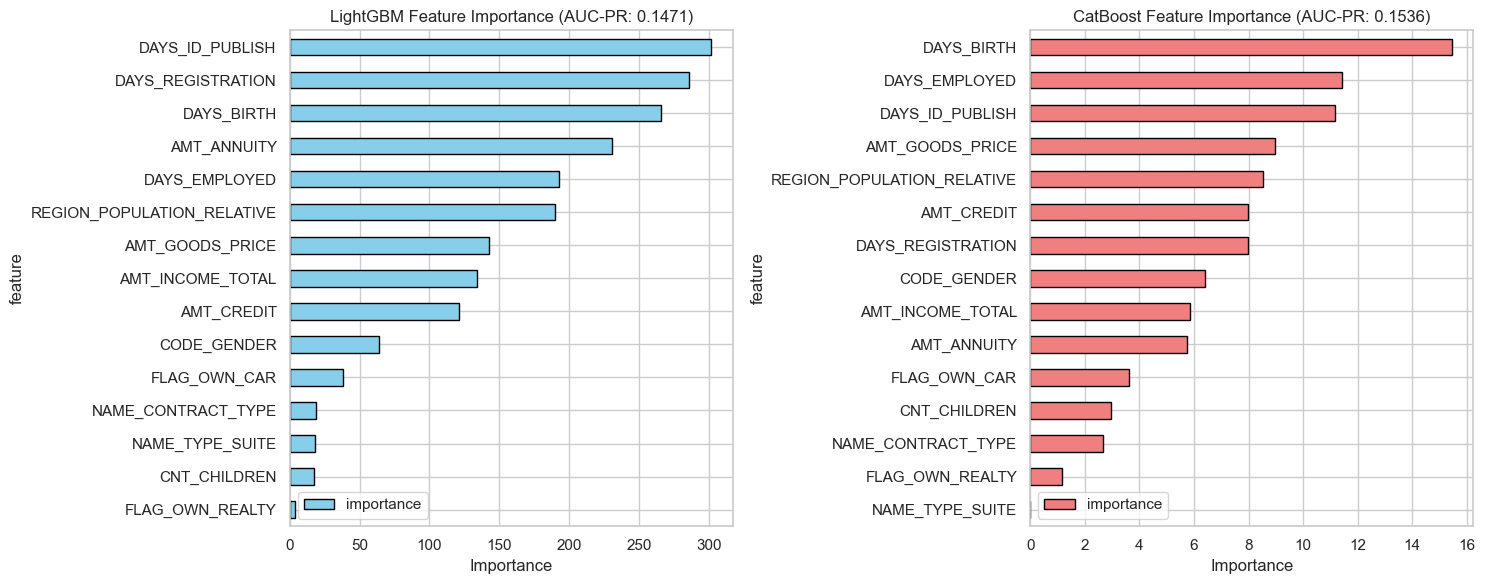


Сравнение качества до и после удаления неважных признаков:
                  Model   AUC-PR  Признаков Изменение качества
LightGBM (все признаки) 0.147112         15                  -
      LightGBM (важные) 0.134009          8            -0.0131
CatBoost (все признаки) 0.153586         15                  -
      CatBoost (важные) 0.141307          8            -0.0123

LightGBM: удалено 7 признаков из 15
CatBoost: удалено 7 признаков из 15

Вывод: качество изменилось на 0.0131


In [34]:
def calculate_auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

data = pd.read_csv('datasets/HomeCredit/application_train.csv', nrows=10000)
Y = data['TARGET']
X = data.drop(columns=['TARGET', 'SK_ID_CURR'])

cat_cols = X.select_dtypes(include=['object']).columns[:5]
num_cols = X.select_dtypes(include=[np.number]).columns[:10]
X = X[num_cols.tolist() + cat_cols.tolist()].copy()

for col in cat_cols:
    X[col] = X[col].fillna('Unknown')
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

cat_indices = [i for i, col in enumerate(X.columns) if col in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y[:len(X)], test_size=0.3, random_state=0, stratify=Y[:len(X)]
)

lgb_model = lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    random_state=0,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]
lgb_score = calculate_auc_pr(y_test, lgb_proba)

cat_model = CatBoostClassifier(
    learning_rate=0.05,
    iterations=100,
    depth=6,
    cat_features=cat_indices,
    random_state=0,
    verbose=False
)
cat_model.fit(X_train, y_train)
cat_proba = cat_model.predict_proba(X_test)[:, 1]
cat_score = calculate_auc_pr(y_test, cat_proba)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

lgb_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=True)
lgb_importances.tail(15).plot(kind='barh', x='feature', y='importance', 
                               ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title(f'LightGBM Feature Importance (AUC-PR: {lgb_score:.4f})')
axes[0].set_xlabel('Importance')

cat_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_model.get_feature_importance()
}).sort_values('importance', ascending=True)
cat_importances.tail(15).plot(kind='barh', x='feature', y='importance', 
                               ax=axes[1], color='lightcoral', edgecolor='black')
axes[1].set_title(f'CatBoost Feature Importance (AUC-PR: {cat_score:.4f})')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

lgb_threshold = lgb_importances['importance'].quantile(0.5)
lgb_important_features = lgb_importances[lgb_importances['importance'] >= lgb_threshold]['feature']
X_train_lgb_reduced = X_train[lgb_important_features]
X_test_lgb_reduced = X_test[lgb_important_features]

lgb_model_reduced = lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=5,
    random_state=0,
    verbose=-1
)
lgb_model_reduced.fit(X_train_lgb_reduced, y_train)
lgb_proba_reduced = lgb_model_reduced.predict_proba(X_test_lgb_reduced)[:, 1]
lgb_score_reduced = calculate_auc_pr(y_test, lgb_proba_reduced)

cat_threshold = cat_importances['importance'].quantile(0.5)
cat_important_features = cat_importances[cat_importances['importance'] >= cat_threshold]['feature']
X_train_cat_reduced = X_train[cat_important_features]
X_test_cat_reduced = X_test[cat_important_features]
cat_indices_reduced = [i for i, col in enumerate(cat_important_features) if col in cat_cols]

cat_model_reduced = CatBoostClassifier(
    learning_rate=0.05,
    iterations=100,
    depth=6,
    cat_features=cat_indices_reduced,
    random_state=0,
    verbose=False
)
cat_model_reduced.fit(X_train_cat_reduced, y_train)
cat_proba_reduced = cat_model_reduced.predict_proba(X_test_cat_reduced)[:, 1]
cat_score_reduced = calculate_auc_pr(y_test, cat_proba_reduced)

results = pd.DataFrame({
    'Model': ['LightGBM (все признаки)', 'LightGBM (важные)', 
              'CatBoost (все признаки)', 'CatBoost (важные)'],
    'AUC-PR': [lgb_score, lgb_score_reduced, cat_score, cat_score_reduced],
    'Признаков': [X.shape[1], len(lgb_important_features), 
                  X.shape[1], len(cat_important_features)],
    'Изменение качества': ['-', f'{lgb_score_reduced - lgb_score:+.4f}', 
                           '-', f'{cat_score_reduced - cat_score:+.4f}']
})

print("\nСравнение качества до и после удаления неважных признаков:")
print(results.to_string(index=False))

print(f"\nLightGBM: удалено {X.shape[1] - len(lgb_important_features)} признаков из {X.shape[1]}")
print(f"CatBoost: удалено {X.shape[1] - len(cat_important_features)} признаков из {X.shape[1]}")

if abs(lgb_score_reduced - lgb_score) < 0.01 and abs(cat_score_reduced - cat_score) < 0.01:
    print("\nВывод: качество практически не изменилось после удаления неважных признаков")
else:
    print(f"\nВывод: качество изменилось на {max(abs(lgb_score_reduced - lgb_score), abs(cat_score_reduced - cat_score)):.4f}")